In [9]:
### Initialize & Read in data ###

from pylab import *
import numpy as np
import scipy as sp
import time
import os

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.collections import LineCollection
%matplotlib inline 
# Normal matplotlib => just wrap in $ for latex

#import mpld3 # This is a widget for zooming in and manipulating plots
#mpld3.enable_notebook()

from sklearn import gaussian_process

In [7]:
### 27912 tracks numbers, 27891 total tracks ###
### Cut matrix: 1000 track numbersm 992 total tracks ###
### Create data matrix ###

dir_path = '/Users/michaelzevin/Documents/Stellar Evolution/Data/npy_resampled_cut/'

### Read in the inputs for each track ###
inputs = []
outputs_1 = []
outputs_2 = []

for file in os.listdir(dir_path):
    x = np.load(dir_path + file)
    
    inputs.append([[float(x['Mbh_init'])],[float(x['M2_init'])],[float(x['P_init'])]])
        
    outputs_1.append(x['xr1'])
    outputs_2.append(x['xr2'])
        
    # Could also try to run GP for each timestep separately
        
inputs = np.reshape(inputs,[len(inputs),3])

The initial conditions for track 500 are: Mbh = 8.000000, M2 = 0.995086, & P = 1.494279


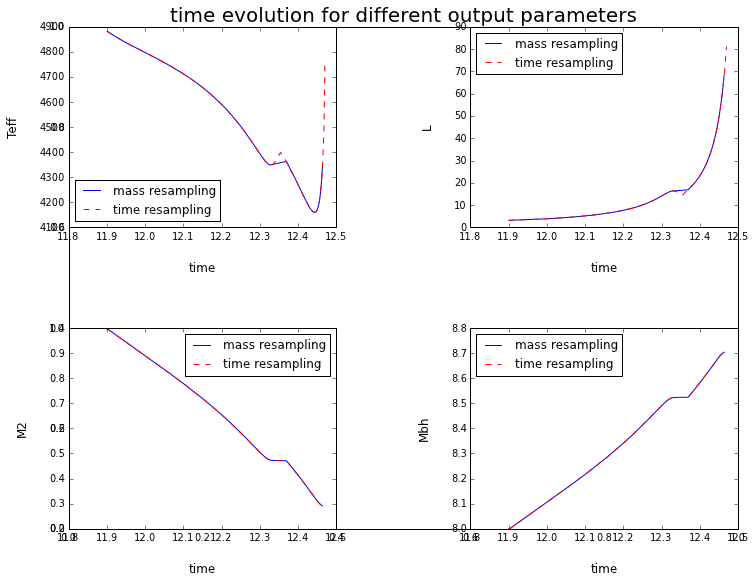

In [10]:
'''Run some time evolution tracks for both resampling'''

### Set up plots ###
fig=plt.figure(figsize = (12,9), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)
plt.title('time evolution for different output parameters', size=20)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs=[ax1,ax2,ax3,ax4]

#set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['blue'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])

#plt.xlabel('time (Gyr)', labelpad=20, size=15)
#plt.ylabel('logT', rotation=90, labelpad=20, size=15)

### POSSIBLE OUTPUTS TO PLOT ###
'''
(0'log_dt', 1'he_core_mass', 2'LH', 3'LHe', 4'Teff', 5'L', 
 6'R', 7'logg', 8'center_H1', 9'center_He4', 10'num_retries', 
 11'model', 12'age', 13'P', 14'A', 15'rl_relative_overflow', 16'M2', 
 17'Mbh', 18'log_abs_mdot', 19'xfer_fraction')
 '''
age_index = 12
timesteps = np.linspace(0,999,1000)

### Choose the track number you want to look at ###
track = 500
print 'The initial conditions for track %i are: Mbh = %f, M2 = %f, & P = %f' % (track,inputs[track,0],inputs[track,1],inputs[track,2])
    
### Choose 4 outputs to plot time evolution ###
evo=[4,5,16,17]    

### For labeling, reference a sample path ###
sample_path = '/Users/michaelzevin/Documents/Stellar Evolution/Data/npy_resampled/file1.npz'
x = np.load(sample_path)


for i in xrange(len(axs)):
    
    # Set up subplot
    ax = axs[i]
    ax = fig.add_subplot(2,2,i+1)
    ax.set_xlabel('time', rotation=0, labelpad=20, size=12)
    ax.set_ylabel(x['xr1'].dtype.names[evo[i]], rotation=90, labelpad=20, size=12)
    ax.legend([lc1, lc2], ['mass resampling', 'time resampling'], loc=0)
    
    # Pick out interpolation for each correlation and plot
    resample_1=[]
    resample_2=[]
    time_1=[]
    time_2=[]
    for j in xrange(1000):
        resample_1.append(outputs_1[track][j][evo[i]])
        resample_2.append(outputs_2[track][j][evo[i]])
        time_1.append((outputs_1[track][j][age_index])/10**9)
        time_2.append((outputs_2[track][j][age_index])/10**9)
    ax.plot(time_1, resample_1, 'b-')
    ax.plot(time_2, resample_2, 'r--')
    
plt.show()


In [69]:
'''Convert list into matrix of shape (track,parameter,timestep)'''
matrix_1; matrix_2 = np.zeros((len(outputs_1),1000,20))
data_1 = np.array(outputs_1)
data_2 = np.array(outputs_2)

for i in xrange(len(data)):
    for j in xrange(1000):
        for k in xrange(20):
            matrix_1[i,j,k]=data_1[i,j][k]
            matrix_2[i,j,k]=data_2[i,j][k]
            
matrix_1 = np.swapaxes(matrix_1,1,2)
matrix_2 = np.swapaxes(matrix_2,1,2)

In [107]:
'''Pick random IC to leave out, interpolate over this and compare with actual'''
q=randint(0,len(inputs))
temp = list(inputs)
random_IC = array(temp.pop(q))
temp = array(temp)

temp_out_1 = list(matrix_1)
temp_out_2 = list(matrix_2)
temp_out_1.pop(q)
temp_out_2.pop(q)
temp_out_1 = array(temp_out_1)
temp_out_2 = array(temp_out_2)

print "The randomly-selected track is %i with initial conditions Mbh = %f, M2 = %f, & P = %f" % (q,random_IC[0],random_IC[1],random_IC[2])



The randomly-selected track is 668 with initial conditions Mbh = 1.400000, M2 = 1.085929, & P = 15.499030


In [117]:
'''Run GP on the remaining dataset'''

def GP(x, y):
    gp = gaussian_process.GaussianProcess(corr='absolute_exponential', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,nugget=2e-5)
    ''' other corr: 'absolute_exponential', 'squared_exponential', 'generalized_exponential', 'cubic', 'linear' '''
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    
    gp.fit(x, y)
    
    x_pred = np.atleast_2d(random_IC)
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return x_pred, y_pred, sigma


### Run GP for each timestep, not including the one left out ###

# Run for the first resampling
x_pred_1=[]; y_pred_1=[]; sigma_1=[]
start_time = time.time()
for i in xrange(0,1000):
    x_GP, y_GP, sigma_GP = GP(temp,temp_out_1[:,:,i])
    x_pred_1.append(x_GP)
    y_pred_1.append(y_GP)
    sigma_1.append(sigma_GP)
    
    print i

elapsed = time.time() - start_time # See how long it took
print 'It only took %f seconds!' % (elapsed)


# Run for the second resampling
start_time = time.time()
x_pred_2=[]; y_pred_2=[]; sigma_2=[]
for i in xrange(0,1000):
    x_GP, y_GP, sigma_GP = GP(temp,temp_out_2[:,:,i])
    x_pred_2.append(x_GP)
    y_pred_2.append(y_GP)
    sigma_2.append(sigma_GP)
    
    print i

elapsed = time.time() - start_time # See how long it took
print 'It only took %f seconds!' % (elapsed)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [146]:
interp_1[:,evo]

array([ 4439.13665994,  4435.30053442,  4434.35813653,  4433.63526338,
        4433.11961564,  4432.38860359,  4431.87775485,  4431.38726729,
        4431.1670711 ,  4430.50691457,  4429.99598761,  4429.57269753,
        4428.5606848 ,  4427.63927568,  4426.44447504,  4425.26159536,
        4424.32819253,  4423.23137905,  4422.70244907,  4421.66882033,
        4420.84824684,  4419.9043917 ,  4420.14808876,  4418.47506909,
        4417.7078602 ,  4416.99255918,  4416.59405477,  4415.53147121,
        4415.27449575,  4414.22893232,  4414.67598552,  4413.08970375,
        4412.40067888,  4412.73372449,  4411.47942415,  4410.32290349,
        4410.22238456,  4409.89701667,  4408.45981941,  4408.57773899,
        4408.03544351,  4408.21939339,  4406.98639666,  4407.09932313,
        4405.57061484,  4405.71498124,  4404.60172294,  4404.88100774,
        4403.16148098,  4402.92555021,  4402.66984001,  4403.13837548,
        4402.84957993,  4402.45902342,  4401.25901058,  4400.38427185,
      

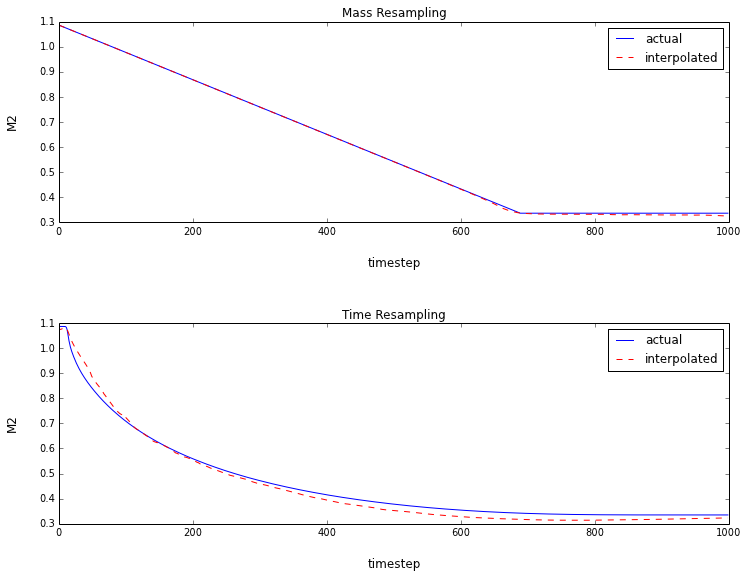

In [164]:
# '''Plot evolution tracks for actual and interpolated'''

actual_1 = matrix_1[q]
actual_2 = matrix_2[q]
interp_1 = np.reshape(y_pred_1,(1000,20))
interp_2 = np.reshape(y_pred_2,(1000,20))

parameters=['log_dt', 'he_core_mass', 'LH', 'LHe', 'Teff', 'L', 
    'R', 'logg', 'center_H1', 'center_He4', 'num_retries', 
    'model', 'age', 'P', 'A', 'rl_relative_overflow', 'M2', 
    'Mbh', 'log_abs_mdot', 'xfer_fraction']

### Set up plots ###
fig=plt.figure(figsize = (12,9), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['blue'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])

# Set parameter to plot, and make timesteps
param_num = 16
timesteps = np.linspace(0,999,1000)

ax1.set_xlabel('timestep', rotation=0, labelpad=20, size=12)
ax1.set_ylabel(parameters[param_num], rotation=90, labelpad=20, size=12)
ax1.legend([lc1, lc2], ['actual', 'interpolated'], loc=0)
ax1.set_title("Mass Resampling")
ax1.plot(timesteps, actual_1[param_num], 'b-')
ax1.plot(timesteps, interp_1[:,param_num], 'r--')

ax2.set_xlabel('timestep', rotation=0, labelpad=20, size=12)
ax2.set_ylabel(parameters[param_num], rotation=90, labelpad=20, size=12)
ax2.legend([lc1, lc2], ['actual', 'interpolated'], loc=0)
ax2.set_title("Time Resampling")
ax2.plot(timesteps, actual_2[param_num], 'b-')
ax2.plot(timesteps, interp_2[:,param_num], 'r--')
